In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

## Import

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn import model_selection
from sklearn import base
from sklearn.metrics import confusion_matrix

%load_ext autoreload
%autoreload 2
from mypkg.football_ml_dataset import Feature
from mypkg.football_ml_dataset import MatchStatsDataset


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
The data is loaded into MatchStatsDataset objects with data from one season in each. The first n matches in each season are dropped because some history is needed to make predictions. Results from last season is considered inadequate.

In [3]:
path ='./Data/'
# not used for now 'PL0001.csv', 'PL0102.csv', 'PL0203.csv', 'PL0304.csv', 'PL0405.csv',
files = ['PL0506.csv', 'PL0607.csv', 'PL0708.csv', 'PL0809.csv', 'PL0910.csv',
         'PL1011.csv', 'PL1112.csv', 'PL1213.csv','PL1314.csv', 'PL1415.csv',
         'PL1516.csv', 'PL1617.csv', 'PL1718.csv', 'CH1011.csv', 'CH1112.csv',
        'CH1213.csv', 'CH1314.csv', 'CH1415.csv', 'CH1516.csv', 'CH1617.csv', 
        'CH1718.csv']
datasets = []
print('Read csv and initialize MatchStatsDataset objects...')
for file in files:
    try:
        df = pd.read_csv(path+file)
        datasets.append(MatchStatsDataset(df, 50))
    except:
        print('pd.read_csv failed for :' + path+file)

print('Finished! '+ str(len(datasets))+ ' season datasets loaded.')

Read csv and initialize MatchStatsDataset objects...
Finished! 21 season datasets loaded.


## Calc features
Features are calculated from past games.
The dictionary dct_features is creating Feature objects (from football_ml_dataset), that defines which features to calculate.

In [4]:
dct_features = {
            'ht_prcwin_prev15_games':Feature('H', 'prcwin', 15, 'both'),
            'at_prcwin_prev15_games':Feature('A', 'prcwin', 15, 'both'),
            'ht_prcwin_prev5_homegames':Feature('H', 'prcwin', 5, 'home'),
            'at_prcwin_prev5_awaygames':Feature('A', 'prcwin', 5, 'away'),
            #'ht_goalsscored_prev5_homegames':Feature('H', 'goalsscored', 5, 'home'),
            #'at_goalsscored_prev5_awaygames':Feature('A', 'goalsscored', 5, 'away'),
            #'ht_goalsagainst_prev5_homegames':Feature('H', 'goalsagainst', 5, 'home'),
            #'at_goalsagainst_prev5_awaygames':Feature('A', 'goalsagainst',5, 'away'),
            'ht_goalsscoredewma_prev10_games':Feature('H', 'goalsscoredewma', 10, 'both'),
            'at_goalsscoredewma_prev10_games':Feature('A', 'goalsscoredewma', 10, 'both'),
            }

#Calc features and aggregate match data into one dataframe
#The final dataframe contains both features and other match data (like FTR)
print('Calculating features ...')
df = pd.DataFrame()
matches = 0
for i, ds in enumerate(datasets):
    print('Dataset '+ str(i+1))
    dftmp = ds.get_features_and_matchdata(dct_features)
    matches+=dftmp.shape[0]
    df = dftmp if df.empty else df.append(dftmp)

print('Calculated features for ' + str(matches) + ' matches.' )
#Do various postprocessing
df.index = range(df.shape[0])
df = df.dropna()
for col in dct_features:
    df[col] = pd.to_numeric(df[col])
df = df[df.FTR.notnull()]
df = df.dropna()

print(str(df.shape[0]) + ' matches left after post-processing.' )

Calculating features ...
Dataset 1
Dataset 2
Dataset 3
Dataset 4
Dataset 5
Dataset 6
Dataset 7
Dataset 8
Dataset 9
Dataset 10
Dataset 11
Dataset 12
Dataset 13
Dataset 14
Dataset 15
Dataset 16
Dataset 17
Dataset 18
Dataset 19
Dataset 20
Dataset 21
Calculated features for 8308 matches.
5077 matches left after post-processing.


## Explore data
We are looking for feature differences for the result categories. That would make the feature a potential useful variable in the machine learning algorithm

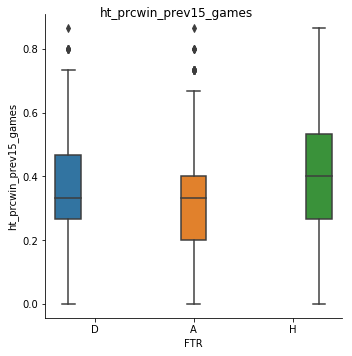

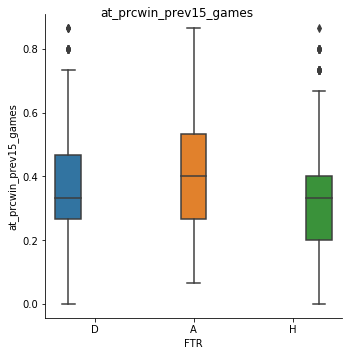

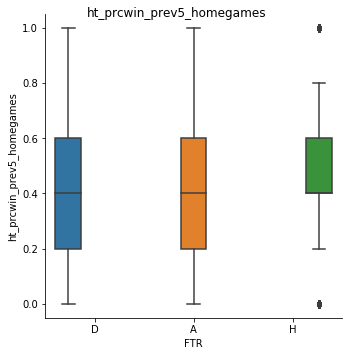

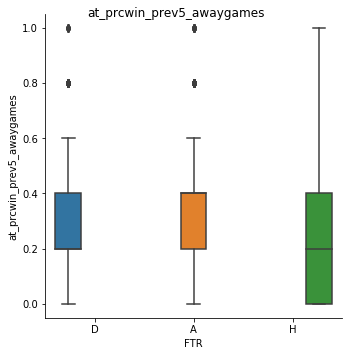

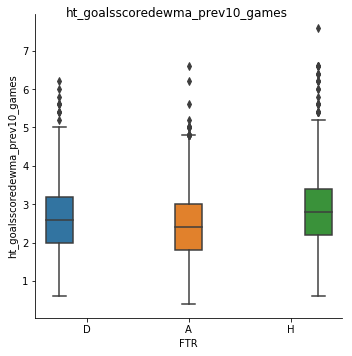

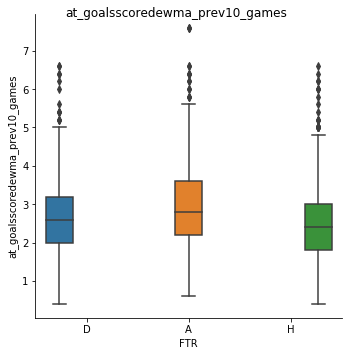

In [5]:
for feature in dct_features:
    #ax = sns.distplot(df[feature])
    #plt.show()
    g = sns.catplot(x='FTR', y=feature, hue='FTR', data=df, kind="box", row_order=['H', 'D', 'A'])
    g.fig.suptitle(feature) 
    

Since there is a lot of overlap between the categories and since I am more interested in the probabilities than the actual predicted classification, I will make random samples from the dataset and plot the features against the probability of each outcome.

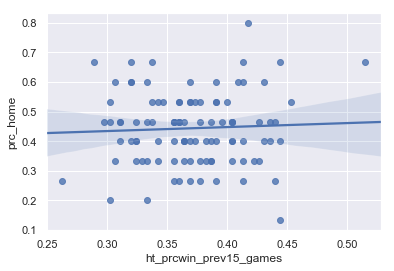

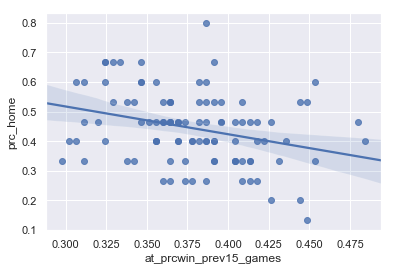

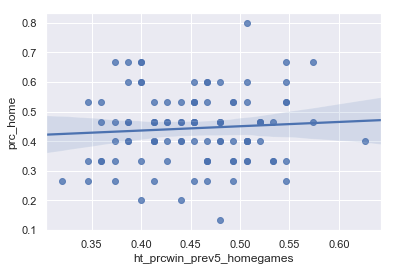

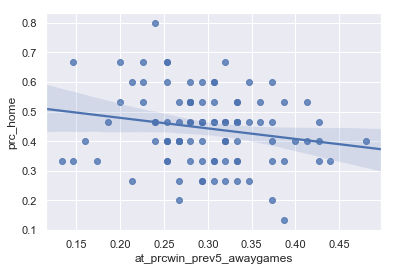

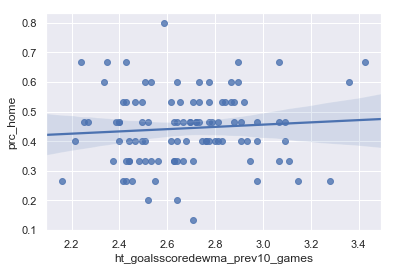

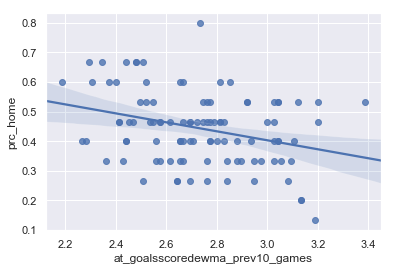

In [6]:
columns = list(dct_features.keys())  + ['prc_home', 'prc_draw', 'prc_away']
df_samples = pd.DataFrame(columns = columns, dtype = float)

for i in range(100):
    sample = df.sample(n=15, random_state=i)
    df_samples.loc[i,:] = sample.mean()
    FTR_count = sample.FTR.value_counts()
    df_samples.loc[i,'prc_home'] = (FTR_count['H']/sample.shape[0]) if 'H' in FTR_count else 0
    df_samples.loc[i,'prc_draw'] = (FTR_count['D']/sample.shape[0]) if 'D' in FTR_count else 0
    df_samples.loc[i,'prc_away'] = (FTR_count['A']/sample.shape[0]) if 'A' in FTR_count else 0
    
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

sns.set()
for col in dct_features:
    #df_samples.plot.scatter(x=col, y='prc_home')
    sns.regplot(data=df_samples, x=col, y='prc_home')
    plt.show()


## Prepare data: split, transform and scale

In [7]:
#Get features and labels as numpy
features = df[dct_features.keys()].to_numpy()
labels = df.FTR.replace({}).replace({'H':0, 'D':1, 'A':2}).to_numpy()

#Split
indx = range(features.shape[0])
test_size = int(features.shape[0]/10)
indx = model_selection.train_test_split(indx, test_size=test_size)
x_train = features[indx[0],:]
y_train = labels[indx[0]]
x_test = features[indx[1]]
y_test = labels[indx[1]]

#Transform to get features that are closer to normal distributed
pt = PowerTransformer(method='yeo-johnson', standardize=False)
pt.fit_transform(x_train)
x_train = pt.transform(x_train)
x_test = pt.transform(x_test)

#Scale
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

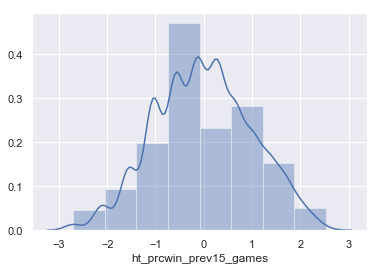

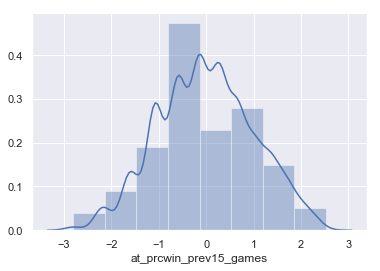

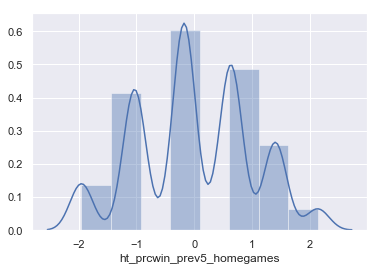

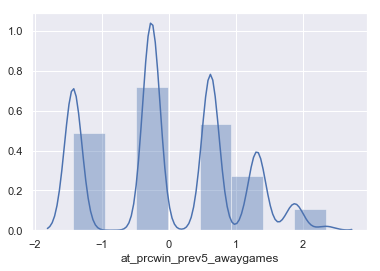

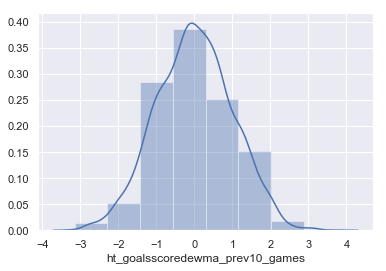

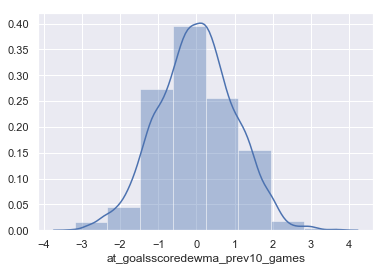

In [8]:
#Plot distributions of transformed and scaled data
df_processed = pd.DataFrame(x_train, columns=list(dct_features.keys()))
for col in df_processed:
    sns.distplot(df_processed[col], bins=8)
    plt.show()

## Fitting models
As a beginning I will use Logistic Regression, Random Forest Classifier and Support Vector Machines

In [9]:
print('Fitting Models ...')

model_logreg = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial')
model_rfc = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
model_svm = SVC(gamma='auto', probability=True)

model_logreg.fit(x_train, y_train)
model_rfc.fit(x_train, y_train)
model_svm.fit(x_train, y_train)

print('Finished!')

Fitting Models ...
Finished!


## Metric
The interesting evaluation is not exactly how well I can predict match outcomes, but if I can predict better than the bookmakers. Therefore, metric I will use is:

$$
\frac{\sum_{i=1}^{n}(p_{ftr_i}*odds_{ftr_i})}{n}
$$
where $n$ is the number of games.

If the metric is $>1$ it means that the model performes better than the bookies and you could make money from the betting strategy.

In [10]:
def calc_metric(model, test_features, test_index):
    """
    Returns the final metric and a list of metrics vs matches, as a tuple.
    """
    model_probs = pd.DataFrame(model.predict_proba(test_features), columns = ['p_home', 'p_draw', 'p_away'])
    match_data = df.iloc[test_index,:]
    match_data.index = range(match_data.shape[0])
    keymap = {'H':'p_home', 'D':'p_draw', 'A':'p_away'}
    metric = 0
    metrics = []
    n = model_probs.shape[0]
    for i in range(n-1):
        ftr = match_data.loc[i, 'FTR']
        metric += (model_probs.loc[i, keymap[ftr]]/match_data.loc[i,keymap[ftr]])
        metrics.append(metric/(i+1))
    metric /= n
    return (metric, metrics)
  
def metric(model, test_features, test_index):
    """
    Returns only the final metric, not the list of metrics vs matches.
    """
    return calc_metric(model, test_features, test_index)[0]

## Evaluate models

Metrics
Log reg: 0.958
RFC: 0.961
SVM: 0.959


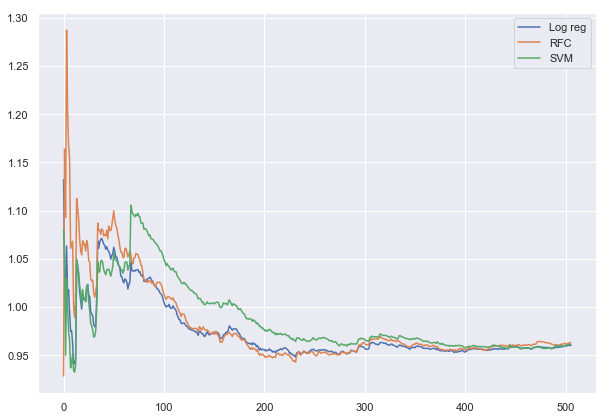

In [11]:
def evaluate_models(dict_of_models):
    fig, ax = plt.subplots()
    fig.set_size_inches(10,7)
    print('Metrics')
    for model_name in dict_of_models:
        mdl = dict_of_models[model_name]
        (mdl_metric, mdl_metrics) = calc_metric(mdl, x_test, indx[1])
        print(model_name+ ': %4.3f' % mdl_metric)
        ax.plot(mdl_metrics, label=model_name)
    
    plt.legend()
    plt.show()

evaluate_models({'Log reg': model_logreg, 'RFC': model_rfc, 'SVM': model_svm})

### Pred quality plot
In this plot I have devided matches into bins based on predicted probabilities and then calculating how many of these matches ended with the given match outcome.

To the right is a scatterplot of model vs bookie probabilities. Green dots is when the match ended with that outcome. If the green dots are below the black line it means that the model earns money on that match.

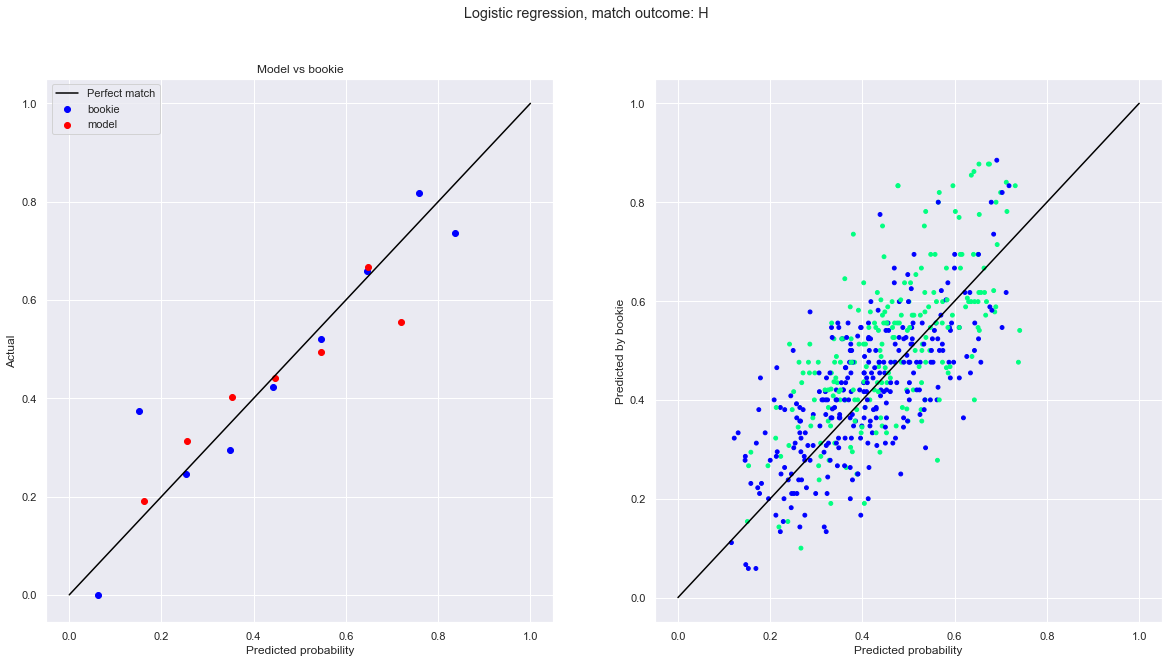

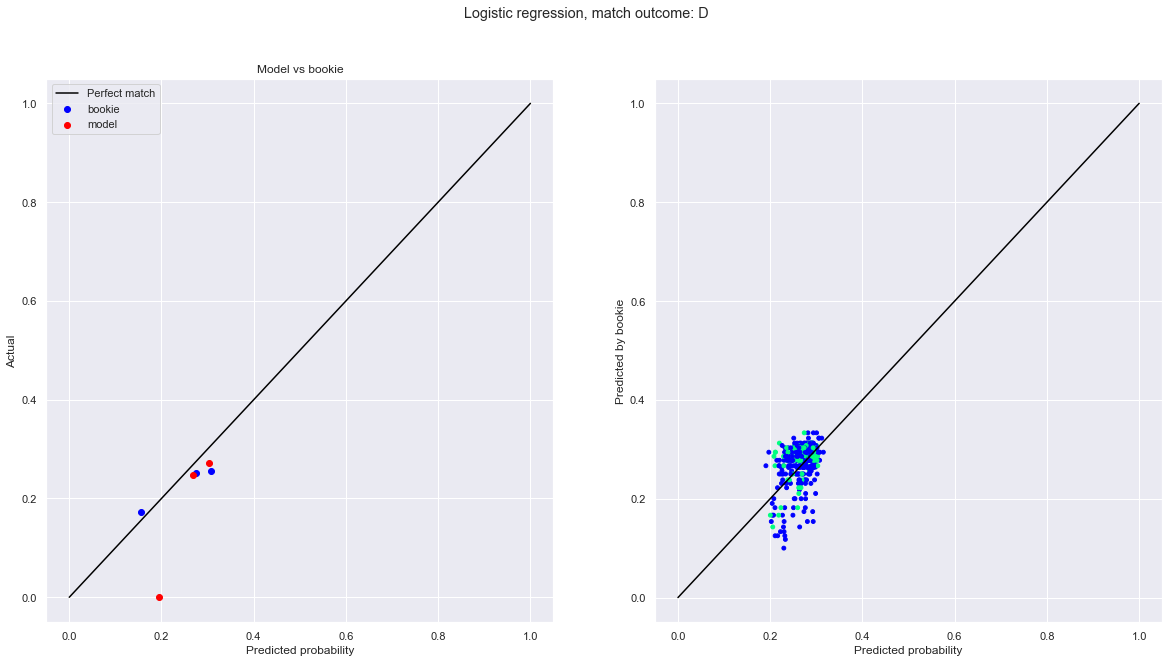

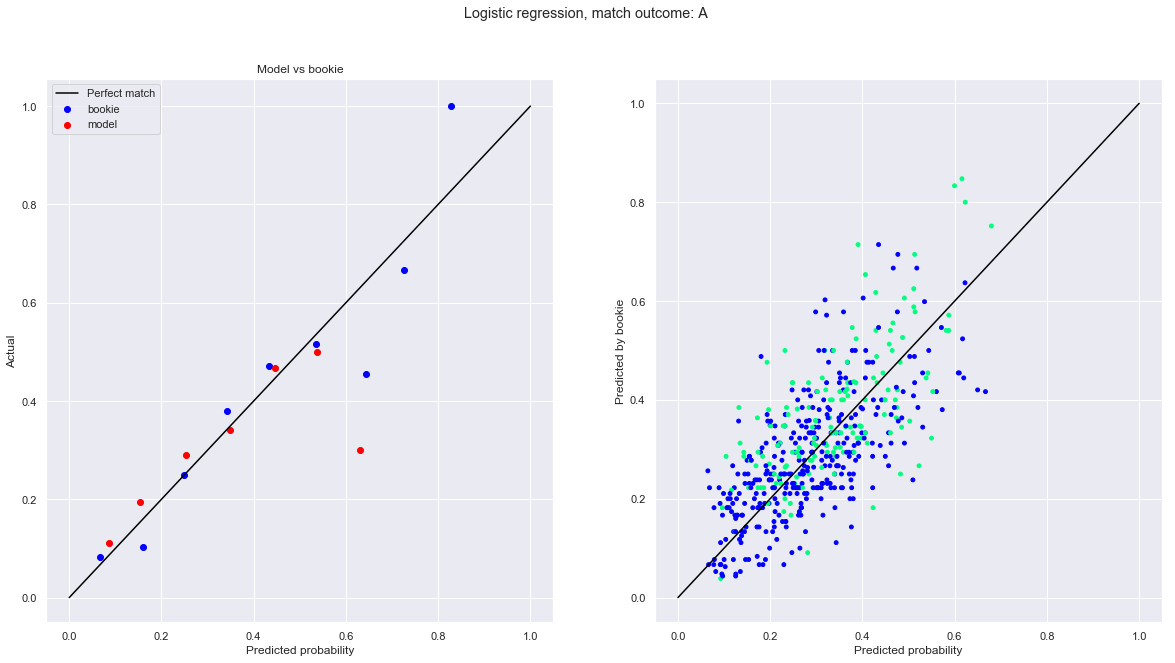

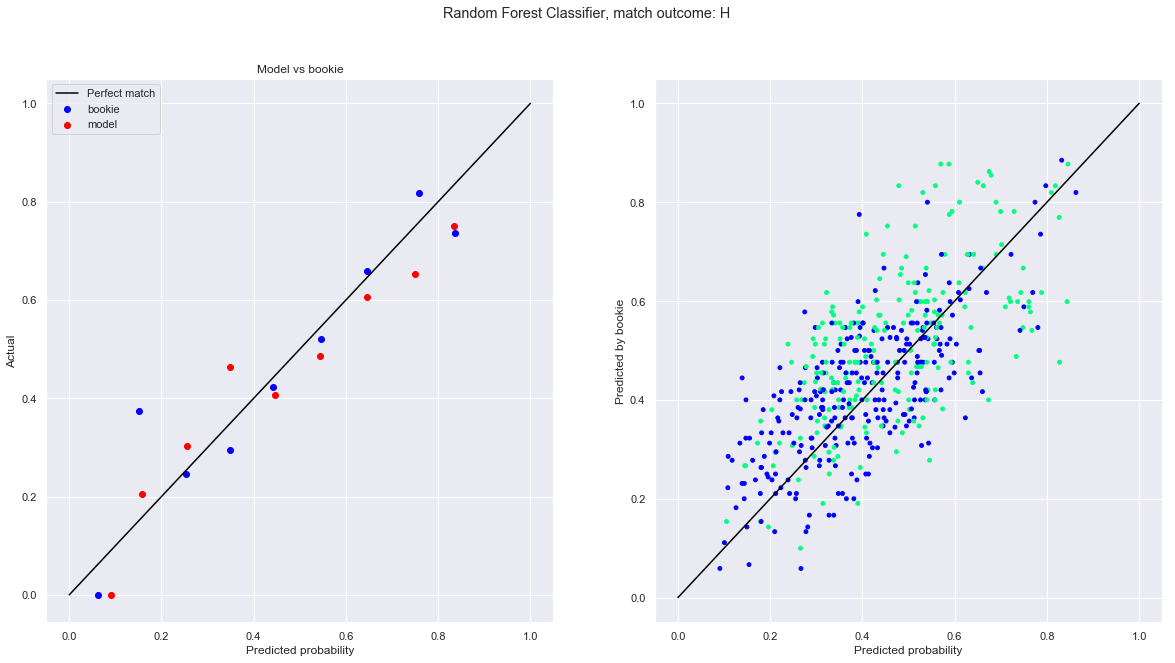

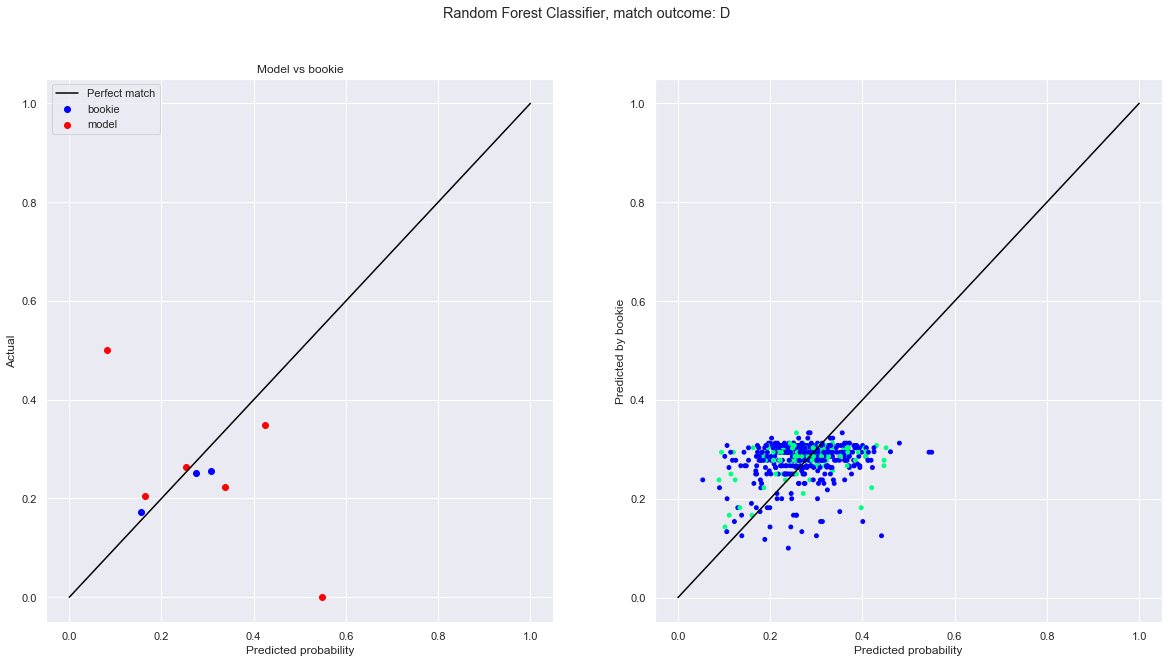

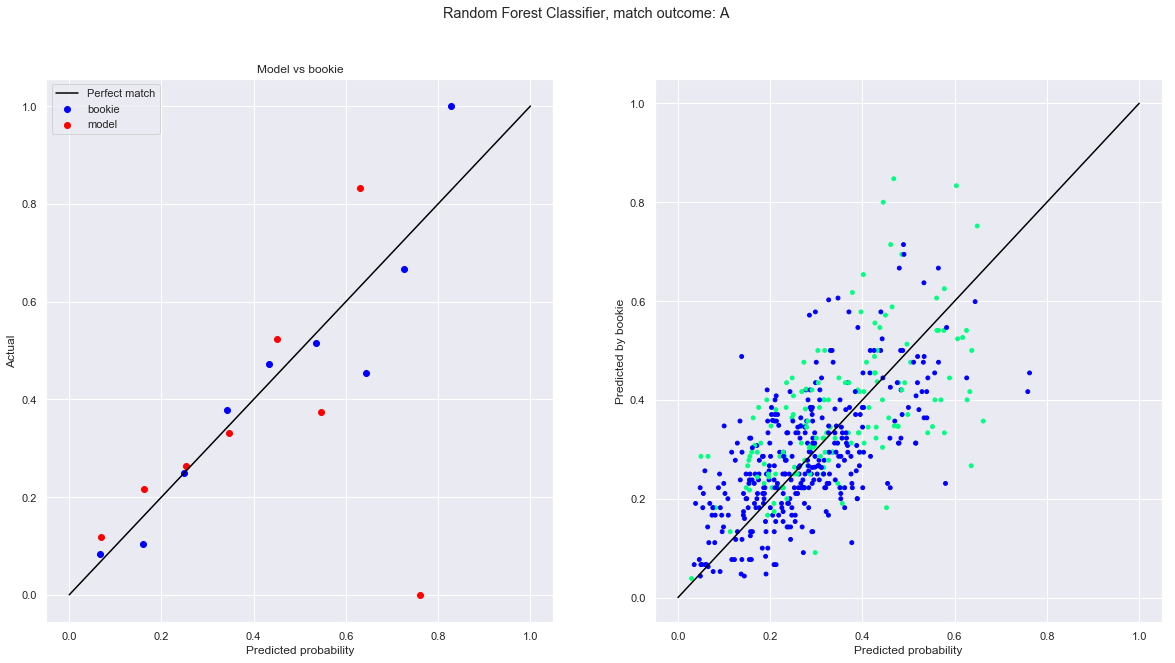

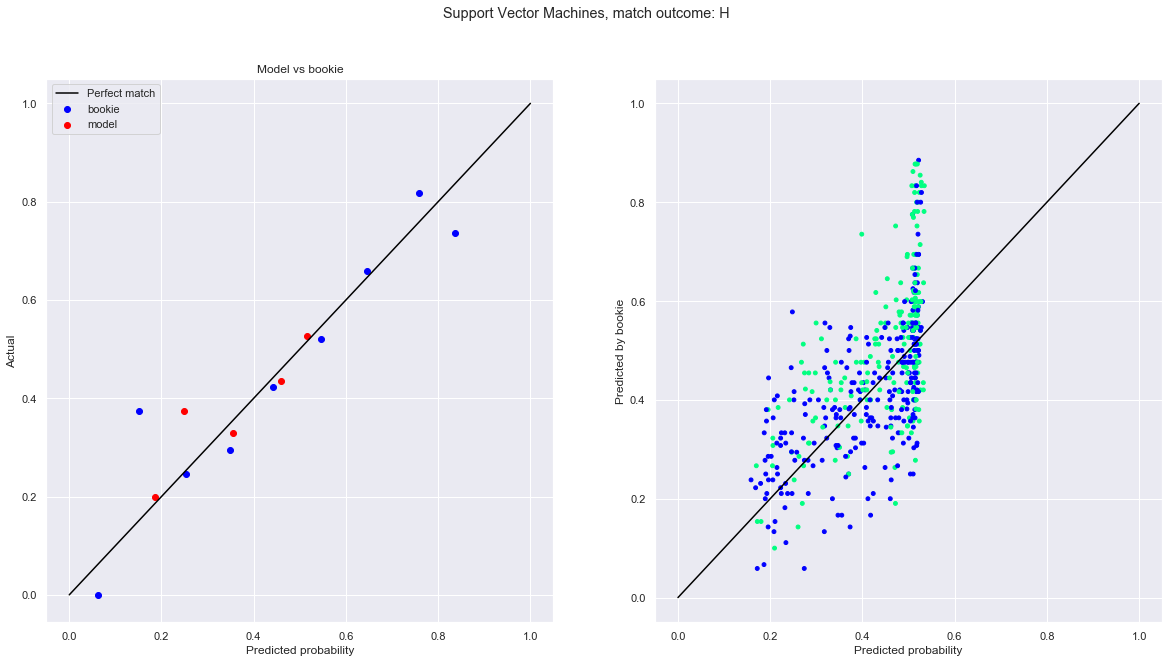

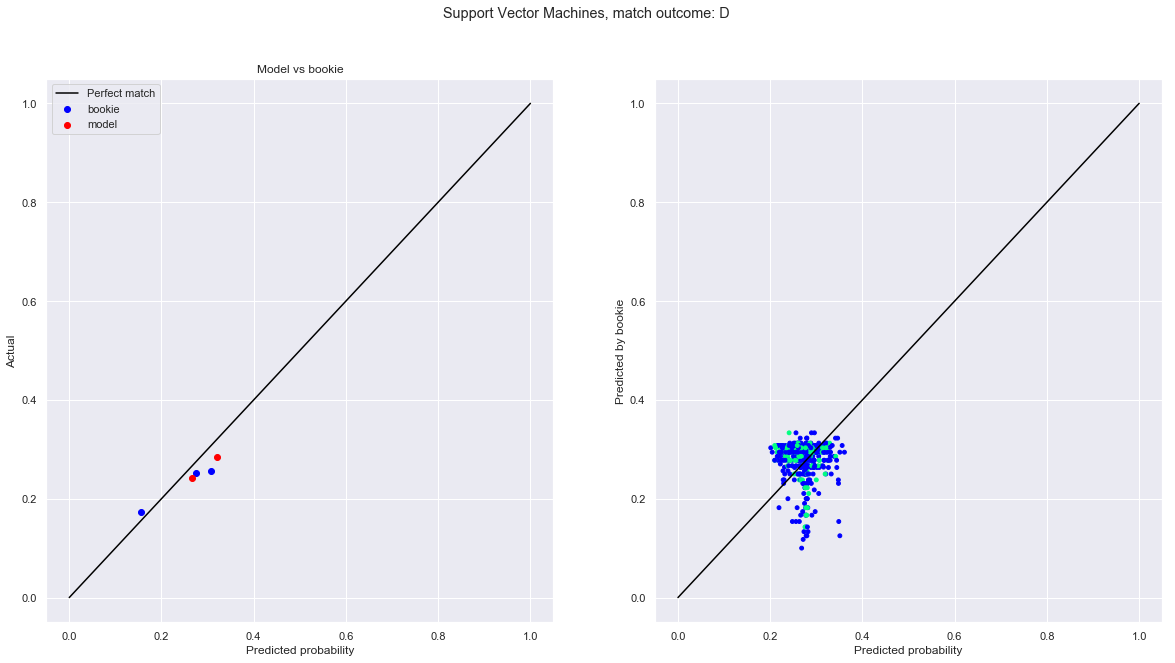

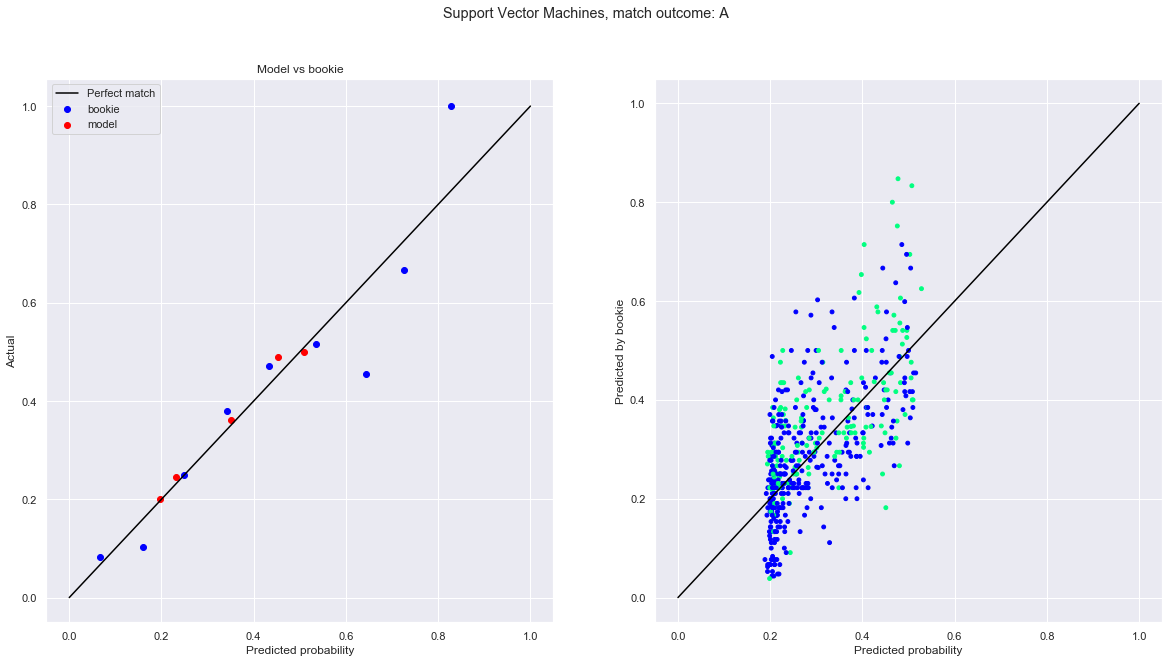

In [12]:
def pred_quality_plot(match_outcome, model, model_name, bins=10):

    model_probs = pd.DataFrame(model.predict_proba(x_test), columns = ['p_home', 'p_draw', 'p_away'])
    bookie_probs = df.iloc[indx[1],:]
    bookie_probs.index = range(bookie_probs.shape[0])
    model_probs['FTR'] = bookie_probs['FTR']
    colors = {'H':1,'D':1,'A':1}
    colors[match_outcome] = 2
    model_probs['Colors'] = model_probs.FTR.replace(colors)

    p_bins = [x/bins for x in range(bins)]
    
    keymap = {'H':'p_home', 'D':'p_draw', 'A':'p_away'}
    key = keymap[match_outcome]
    
    est_bookie, est_model, act_bookie, act_model = [], [], [], []
    
    for p in p_bins:
        #bookmaker
        df_bookie = bookie_probs[bookie_probs[key] >= p]
        df_bookie = df_bookie[df_bookie[key] < p+1/bins]
        #model
        df_model = model_probs[model_probs[key] >= p]
        df_model = df_model[df_model[key] < p+1/bins]
            
        count_act_b = df_bookie.FTR.value_counts()
        count_act_m = df_model.FTR.value_counts()
            
        est_bookie.append(df_bookie[key].mean())
        est_model.append(df_model[key].mean())
        
        val = count_act_b[match_outcome]/df_bookie.shape[0] if match_outcome in count_act_b.index else 0
        act_bookie.append(val)
        
        val = count_act_m[match_outcome]/df_model.shape[0] if match_outcome in count_act_m.index else 0
        act_model.append(val)
    
    fig, axes = plt.subplots(1, 2)
    fig.suptitle(model_name + ', match outcome: ' + match_outcome)
    fig.set_size_inches(20, 10)
    ax = axes[0]
    ax.scatter(est_bookie, act_bookie, color='blue', label='bookie')
    ax.scatter(est_model, act_model, color='red', label='model')
    ax.plot([0,1], [0,1], label='Perfect match', color='black')
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('Actual')
    ax.set_title('Model vs bookie')
    ax.legend()
    
    ax = axes[1]
    ax.scatter(model_probs[key], bookie_probs[key], c=model_probs.Colors.tolist(), cmap='winter', marker='o', s=15)
    ax.plot([0,1], [0,1], color='black')
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('Predicted by bookie')
    
pred_quality_plot('H', model_logreg, 'Logistic regression')
pred_quality_plot('D', model_logreg, 'Logistic regression')
pred_quality_plot('A', model_logreg, 'Logistic regression')

pred_quality_plot('H', model_rfc, 'Random Forest Classifier')
pred_quality_plot('D', model_rfc, 'Random Forest Classifier')
pred_quality_plot('A', model_rfc, 'Random Forest Classifier')

pred_quality_plot('H', model_svm, 'Support Vector Machines')
pred_quality_plot('D', model_svm, 'Support Vector Machines')
pred_quality_plot('A', model_svm, 'Support Vector Machines')

### Confusion matrixes
Vertical axis: true label (H, D and A).
Horizontal axis: predicted label (H, D and A).
Even though we are more interested in the probabilities than the actual predicted outcomes from the models, it is still interesting to look at the confusion matrixes. F.ex it is interesting that there is much more A predicted H than H predicted A, in all models.

In [22]:
print('Confusion matrix logreg')
cm_logreg = confusion_matrix(y_test, model_logreg.predict(x_test))
print(cm_logreg)
print('---')
print('Confusion matrix rfc')
cm_rfc = confusion_matrix(y_test, model_rfc.predict(x_test))
print(cm_rfc)
print('---')
print('Confusion matrix svm')
cm_svm = confusion_matrix(y_test, model_svm.predict(x_test))
print(cm_svm)

Confusion matrix logreg
[[169   0  54]
 [ 93   0  33]
 [ 88   0  70]]
---
Confusion matrix rfc
[[154  24  45]
 [ 79  14  33]
 [ 82  12  64]]
---
Confusion matrix svm
[[179   0  44]
 [ 96   1  29]
 [ 95   1  62]]


## Cross Validation

In [13]:
skfolds = model_selection.StratifiedKFold(n_splits=5, random_state=42)
logreg_metrics, rfc_metrics, svm_metrics = [], [], []

for i, (train_index, test_index) in enumerate(skfolds.split(x_train, y_train)):
    clone_logreg = base.clone(model_logreg)
    clone_rfc = base.clone(model_rfc)
    clone_svm = base.clone(model_svm)
    
    x_train_folds = features[train_index]
    y_train_folds = labels[train_index]
    x_test_folds = features[test_index]
    y_test_folds = labels[test_index]
    
    clone_logreg.fit(x_train_folds, y_train_folds)
    clone_rfc.fit(x_train_folds, y_train_folds)
    clone_svm.fit(x_train_folds, y_train_folds)
    
    logreg_metric = metric(clone_logreg, x_test_folds, test_index)
    rfc_metric = metric(clone_rfc, x_test_folds, test_index)
    svm_metric = metric(clone_svm, x_test_folds, test_index)
    
    logreg_metrics.append(logreg_metric)
    rfc_metrics.append(rfc_metric)
    svm_metrics.append(svm_metric)
    
    print('Fold %2d' % (i+1))
    print('Log. reg Metric: %4.3f' % logreg_metric)
    print('RFC Metric: %4.3f' % rfc_metric)
    print('SVM Metric: %4.3f' % svm_metric)
    print('  ')

print('Means:')
print('Logreg: %4.3f' % statistics.mean(logreg_metrics))
print('RFC: %4.3f' % statistics.mean(rfc_metrics))
print('SVM: %4.3f' % statistics.mean(svm_metrics))
print('Standard deviations:')
print('Logreg: %4.3f' % statistics.stdev(logreg_metrics))
print('RFC: %4.3f' % statistics.stdev(rfc_metrics))
print('SVM: %4.3f' % statistics.stdev(svm_metrics))
 

Fold  1
Log. reg Metric: 0.923
RFC Metric: 0.923
SVM Metric: 0.912
  
Fold  2
Log. reg Metric: 0.960
RFC Metric: 0.955
SVM Metric: 0.955
  
Fold  3
Log. reg Metric: 0.968
RFC Metric: 0.966
SVM Metric: 0.960
  
Fold  4
Log. reg Metric: 0.958
RFC Metric: 0.957
SVM Metric: 0.957
  
Fold  5
Log. reg Metric: 0.990
RFC Metric: 0.987
SVM Metric: 0.979
  
Means:
Logreg: 0.960
RFC: 0.958
SVM: 0.953
Standard deviations:
Logreg: 0.024
RFC: 0.023
SVM: 0.025


### Grid search for the Random Forest Classifier

In [23]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf = RandomForestClassifier()

# Grid search is commented out because it is quite time consuming.
#rf_random = model_selection.RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100,
#                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random = RandomForestClassifier(n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features='sqrt', max_depth=10, bootstrap=True, random_state=42)
rf_random.fit(x_train, y_train)

#print(rf_random.best_params_)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Evaluate the random forest classifier model with the optimal hyper parameters from the grid search.

Since the search took almost 14 minutes I have commented out the copied the result here:
{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}

Metrics
Log reg: 0.958
RFC: 0.961
SVM: 0.959
Optimized RFC: 0.957


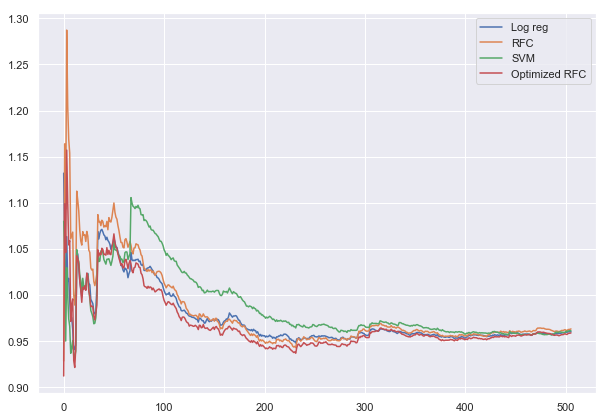

In [24]:
evaluate_models({'Log reg': model_logreg, 'RFC': model_rfc, 'SVM': model_svm, 'Optimized RFC':rf_random})

Surprisingly the optimized RFC model didn't perform better. To improve the performance I have to get back to the feature engineering.